In [1]:
%load_ext Cython

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.ensemble as ske
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV , train_test_split
from stroopwafel import constants , utils
from sklearn import metrics , tree
import seaborn as sns
from numpy import array as A
from sklearn.utils import shuffle
import cython
from cython.parallel import prange , parallel
from cython import nogil
import random
from sklearn.preprocessing import OneHotEncoder
import pickle
from mpl_toolkits import mplot3d
import re

# Function definition



In [3]:
%%cython

# cython: auto_pickle=False
# distutils: extra_compile_args = /openmp
# distutils: extra_link_args = /openmp
# cython: boundscheck = False

import cython
import numpy as np
cimport numpy as np
cimport openmp
from cython.parallel import prange, parallel, threadid
from libc.stdlib cimport malloc, realloc, free, abort
from libc.math cimport cos , sin , sqrt , tan

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.nonecheck(False)
@cython.cdivision(True)

cdef Hot_Encode(int L , int n_class , int n_var , double [:,:] dataset , int [:,:] labels , int num_t):
    
    cdef double [:,:] DATASET = dataset[0:L,:]  
    cdef int [:,:] LABELS = labels[0:L,:]
    cdef int i , j
    cdef int [:] merge = labels[:,0]
    cdef int [:] bbh = labels[:,1]
    cdef double [:,:,:] ds
    
    if n_class >= n_var:
        ds = np.zeros( (2 , L , n_class) )
    else:
        ds = np.zeros( (2 , L , n_var) )

    for i in prange(L , nogil = True , schedule = 'static' , num_threads = num_t):
        
        for j in range(n_var):
            ds[0,i,j] = DATASET[i,j]
        
        if merge[i] == 1 and bbh[i] == 1: # BBH MERGER
            
            if labels[i,2] != 0 and labels[i,3] != 0: # BBH MERGER WITH DOUBLE CE
                ds[1,i,0] = 1
            elif labels[i,2] != 0 and labels[i,3] == 0: # BBH MERGER WITH SINGLE CE
                ds[1,i,0] = 1
            elif labels[i,2] == 0 and labels[i,3] != 0: # BBH MERGER WITH SINGLE CE
                ds[1,i,0] = 1
                
            else: # BBH MERGER WITH NO CE
                ds[1,i,1] = 1
                
        elif merge[i] == 0 and bbh[i] == 1: # BBH NO MERGER:
            
            if labels[i,2] != 0 and labels[i,3] != 0: # BBH NO MERGER WITH DOUBLE CE
                ds[1,i,2] = 1
            elif labels[i,2] != 0 and labels[i,3] == 0: # BBH NO MERGER WITH SINGLE CE
                ds[1,i,2] = 1
            elif labels[i,2] == 0 and labels[i,3] != 0: # BBH NO MERGER WITH SINGLE CE
                ds[1,i,2] = 1
                
            else: # BBH NO MERGER NO CE
                ds[1,i,3] = 1
                
        elif merge[i] == 0 and bbh[i] == 0: # NO BBH NO MERGER
            ds[1,i,4] = 1
        
    return ds

def hotencode(int L , int n_class , int n_var , double [:,:] dataset , int [:,:] labels , int num_t):
    return Hot_Encode(L , n_class , n_var , dataset , labels , num_t)

print('hotencoding ok!')

def Equalize(variable , label , minimum , n , L):
    
    lab = []
    var = []
    
    for i in range(L):
        if label.iloc[i,1] == 1:
            lab.append(label.iloc[i].values)
            var.append(variable.iloc[i].values)

    for N in range(n):
        k = 0
        for j in range(L):
            if label.iloc[j,N] == 1 and k <= minimum-1 and N != 1:
                lab.append(label.iloc[j].values)
                var.append(variable.iloc[j].values)
                k += 1
                
    return np.array(lab) , np.array(var)

print('Equalize ok!')

hotencoding ok!
Equalize ok!


# Dataset preparation for hyperparameters optimization

In [4]:
dataset1 = pd.read_csv('C:/Users/mbaro/OneDrive/Desktop/dataset_ML/samples_LAST_PART1.csv')
dataset2 = pd.read_csv('C:/Users/mbaro/OneDrive/Desktop/dataset_ML/samples_LAST_PART2.csv')#('SAMPLES_TRUE.csv')

frames = [dataset1 , dataset2]

dataset = pd.concat(frames)
print(len(dataset))

n = 5
m = 5
threads = 8
L = 100000#int(len(dataset))

VAR = dataset[['--initial-mass-1' , 'q' , '--metallicity' , '--semi-major-axis' , '--eccentricity']].astype(float)
LAB = dataset[['is_hit' , 'bbh' , 'time_common_enveloe_1' , 'time_common_enveloe_2']].astype(int)

ds = hotencode(L , n , m , VAR.values , LAB.values , threads)

variables = np.array(ds[0,:,0:m])
labels = np.array(ds[1,:,0:n]).astype(int)

names = ['BBH_MERGE_CE' , 'BBH_MERGE' , 'BBH_CE' , 'BBH' , 'NOTHING']

c = 0
for i in range(n):
    c += 100*(np.count_nonzero(labels[:,i] == 1)/len(labels[:,i]))
    print(names[i] ,  '{:.2f}..'.format(100*(np.count_nonzero(labels[:,i] == 1)/len(labels[:,i]))) , '% ---->' , np.count_nonzero(labels[:,i] == 1))

if c >= 99.9:
    print('')
    print('OK! All dataset is represented!')
    
counts = np.zeros(n)
for i in range(n):
    counts[i] = np.count_nonzero(labels[:,i] == 1)
minimum = int(np.min(counts))

print('')
print('Minimum = ' , minimum)
print('')

LABELS = pd.DataFrame(labels , columns = names , dtype = int)
VARIABLES = pd.DataFrame(variables , columns = ['M1' , 'q' , 'Z' , 'a' , 'e'])

lab , var = Equalize(VARIABLES , LABELS , minimum , n , L)

for i in range(n):
    print(names[i] ,  '{:.2f}..'.format(100*(np.count_nonzero(lab[:,i] == 1)/len(lab[:,i]))) , '% ---->' , np.count_nonzero(lab[:,i] == 1))

2000000
BBH_MERGE_CE 0.88.. % ----> 881
BBH_MERGE 0.07.. % ----> 65
BBH_CE 1.10.. % ----> 1096
BBH 6.35.. % ----> 6351
NOTHING 91.61.. % ----> 91607

OK! All dataset is represented!

Minimum =  65

BBH_MERGE_CE 20.00.. % ----> 65
BBH_MERGE 20.00.. % ----> 65
BBH_CE 20.00.. % ----> 65
BBH 20.00.. % ----> 65
NOTHING 20.00.. % ----> 65


In [5]:
datasetX = var

datasetY = lab

Xtrain, Xtest, ytrain, ytest = train_test_split( var , lab , test_size = 0.0001 , random_state = 311996 )

print(len(Xtrain) , len(ytrain) , len(Xtest) , len(ytest))

324 324 1 1


# Random Search

In [6]:
# Number of trees in random forest
n_estimators = np.arange(100 , 10100 , 100).tolist()

# Number of features to consider at every split
max_features = ['sqrt' , 'log2' , 'auto']

# Maximum number of levels in tree
max_depth = np.arange(0,1050,50 , dtype = int).tolist()
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = np.arange(2,11,1).tolist()

# Minimum number of samples required at each leaf node
min_samples_leaf = np.arange(2,11,1).tolist()

# Method of selecting samples for training each tree
bootstrap = [True , False]

criterion = ["gini" , "entropy"]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
print(random_grid)

# Use the random grid to search for best hyperparameters

# Random search of parameters, using 5 fold cross validation, 
# search across 60 different combinations, and use all available cores

rf_random = RandomizedSearchCV( estimator = ske.RandomForestClassifier(n_jobs = -1) , 
                                param_distributions = random_grid , n_iter = 500 ,
                                cv = 5, verbose = 2 , random_state = 3117102616 ,
                                n_jobs = -1 , pre_dispatch = '2*n_jobs' ) 

# Fit the random search model
rf_random.fit(Xtrain , ytrain)

print(rf_random.best_params_)

print('Best accuracy score: %.4f' , rf_random.best_score_)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000], 'max_features': ['sqrt', 'log2', 'auto'], 'max_depth': [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, None], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   37.8s remaining:   33.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   50.3s finished


{'n_estimators': 9500, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'log2', 'max_depth': 800, 'criterion': 'entropy', 'bootstrap': True}
Best accuracy score: %.4f 0.0


# Grid Search

In [29]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [70 , 80 , 90 , 100 , 110 , 120 , 130],
    'n_estimators': [6225 , 6250 , 6275 , 6300 , 6325 , 6350 , 6375],
    'min_samples_leaf': [2],
    'min_samples_split': [4]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = ske.RandomForestClassifier(max_features = 'auto',
                                                                  bootstrap = False , criterion = "entropy",
                                                                  n_jobs = -1),
                           param_grid = param_grid, 
                           cv = 5, n_jobs = -1, verbose = 2 , pre_dispatch = '2*n_jobs')

grid_search.fit(Xtrain , ytrain)

print(grid_search.best_params_)
print('Best accuracy score: %.4f' , grid_search.best_score_)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed: 21.3min finished


{'max_depth': 80, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 6375}
Best accuracy score: %.4f 0.5464423076923077


# Dataset preparation for training and testing

In [30]:
dataset1 = pd.read_csv('C:/Users/mbaro/OneDrive/Desktop/dataset_ML/samples_LAST_PART1.csv')
dataset2 = pd.read_csv('C:/Users/mbaro/OneDrive/Desktop/dataset_ML/samples_LAST_PART2.csv')#('SAMPLES_TRUE.csv')

frames = [dataset1 , dataset2]

dataset = pd.concat(frames)

VAR = dataset[['--initial-mass-1' , 'q' , '--metallicity' , '--semi-major-axis' , '--eccentricity']].astype(float)
LAB = dataset[['is_hit' , 'bbh' , 'time_common_enveloe_1' , 'time_common_enveloe_2']].astype(int)
n = 5
m = 5
threads = 8
L = len(dataset)

ds = hotencode(L , n , m , VAR.values , LAB.values , threads)

variables = np.array(ds[0,:,0:m])
labels = np.array(ds[1,:,0:n]).astype(int)

names = ['BBH_MERGE_CE' , 'BBH_MERGE' , 'BBH_CE' , 'BBH' , 'NOTHING']

c = 0
for i in range(n):
    c += 100*(np.count_nonzero(labels[:,i] == 1)/len(labels[:,i]))
    print(names[i] ,  '{:.2f}..'.format(100*(np.count_nonzero(labels[:,i] == 1)/len(labels[:,i]))) , '% ---->' , np.count_nonzero(labels[:,i] == 1))

if c >= 99.9:
    print('')
    print('OK! All the dataset is represented!')
    
counts = np.zeros(n)
for i in range(n):
    counts[i] = np.count_nonzero(labels[:,i] == 1)
minimum = int(np.min(counts))

print('')
print('Minimum = ' , minimum)
print('')

LABELS = pd.DataFrame(labels , columns = names , dtype = int)
VARIABLES = pd.DataFrame(variables , columns = ['M1' , 'q' , 'Z' , 'a' , 'e'])

lab , var = Equalize(VARIABLES , LABELS , minimum , n , L)

for i in range(n):
    print(names[i] ,  '{:.2f}..'.format(100*(np.count_nonzero(lab[:,i] == 1)/len(lab[:,i]))) , '% ---->' , np.count_nonzero(lab[:,i] == 1))

datasetX = var

datasetY = lab

Xtrain, Xtest, ytrain, ytest = train_test_split( datasetX , datasetY ,
                                                 test_size = 0.2 , random_state = 754863321 )

print(len(Xtrain) , len(ytrain) , len(Xtest) , len(ytest))

BBH_MERGE_CE 5.98.. % ----> 119615
BBH_MERGE 0.27.. % ----> 5322
BBH_CE 3.84.. % ----> 76810
BBH 12.34.. % ----> 246805
NOTHING 77.57.. % ----> 1551448

OK! All the dataset is represented!

Minimum =  5322

BBH_MERGE_CE 20.00.. % ----> 5322
BBH_MERGE 20.00.. % ----> 5322
BBH_CE 20.00.. % ----> 5322
BBH 20.00.. % ----> 5322
NOTHING 20.00.. % ----> 5322
21288 21288 5322 5322


# Training

In [31]:
final_model = ske.RandomForestClassifier(n_estimators = 6375 , min_samples_split = 4 ,
                                         min_samples_leaf = 2 ,
                                         max_features = 'auto' , max_depth = 80 ,
                                         bootstrap = False , criterion = "entropy" , n_jobs = -1)
final_model.fit(Xtrain , ytrain)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=80,
                       min_samples_leaf=2, min_samples_split=4,
                       n_estimators=6375, n_jobs=-1)

# Testing

In [32]:
y_pred = final_model.predict(Xtest)

print('Mean Absolute Error:', metrics.mean_absolute_error(ytest, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ytest, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, y_pred)))
print("Accuracy:",metrics.accuracy_score(ytest, y_pred))

Mean Absolute Error: 0.05558060879368658
Mean Squared Error: 0.05558060879368658
Root Mean Squared Error: 0.2357554003489349
Accuracy: 0.8196166854565953


In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(Xtest, ytest)
y_pred = loaded_model.predict(Xtest)
print(result)

print('Mean Absolute Error:', metrics.mean_absolute_error(ytest, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ytest, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, y_pred)))
print("Accuracy:",metrics.accuracy_score(ytest, y_pred))

# Feature Importance Histogram

a          0.251839
Z          0.234768
M$_{1}$    0.209536
q          0.171893
e          0.131964
dtype: float64


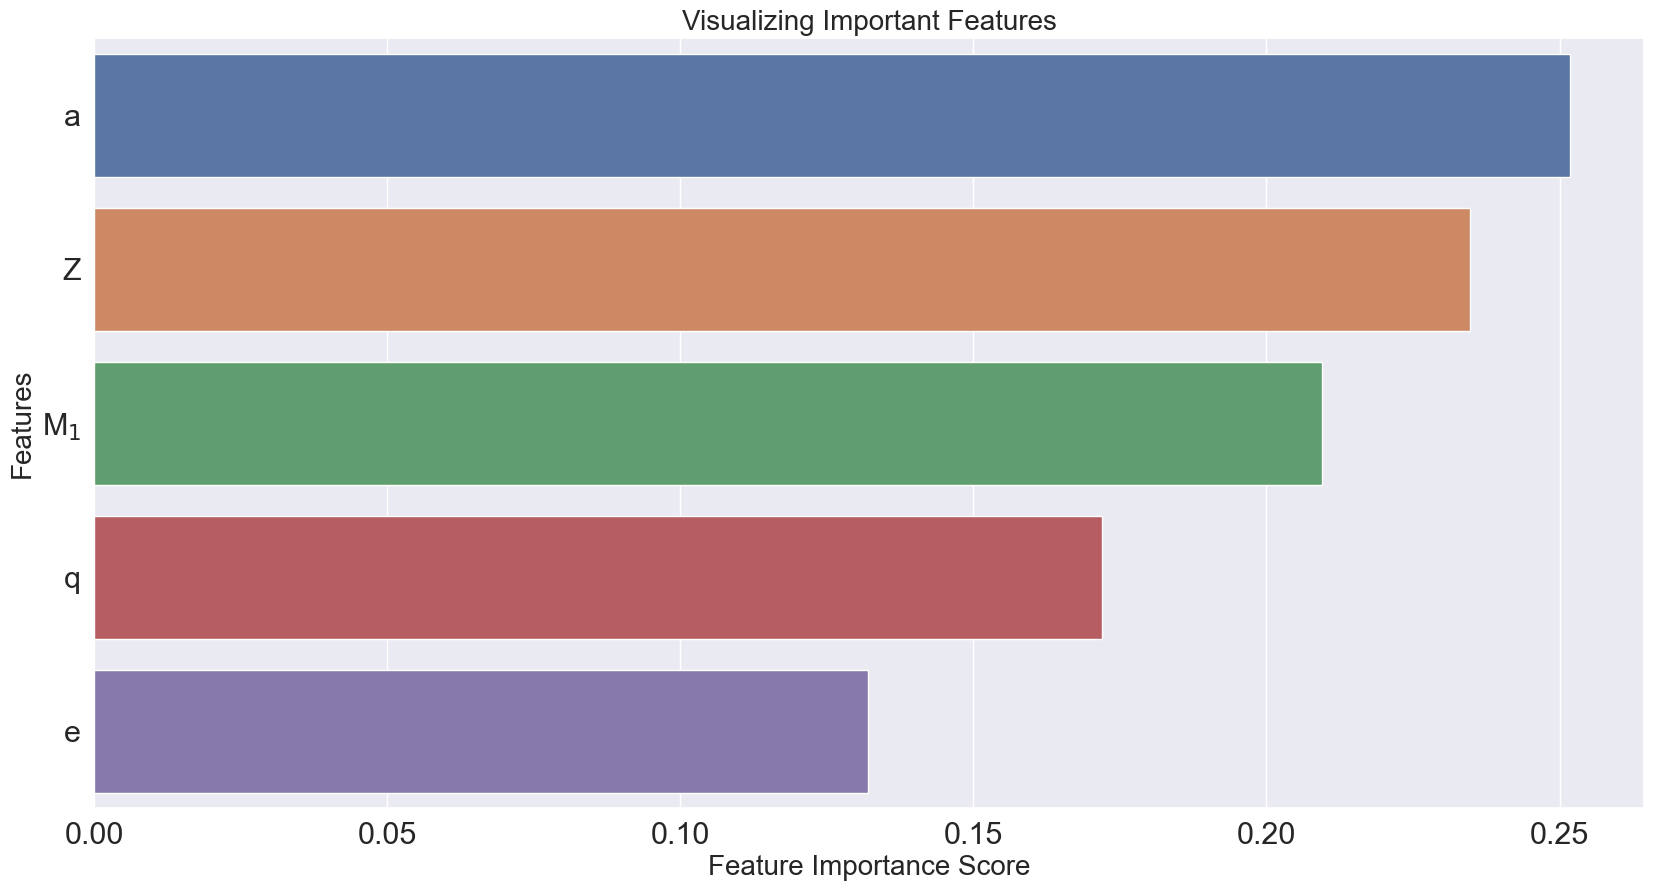

In [33]:
fig = plt.figure(figsize = [20,10])
feature_imp = pd.Series(final_model.feature_importances_ , index=['M$_{1}$' , 'q' , 'Z' , 'a' , 'e']).sort_values(ascending=False)
print(feature_imp)

sns.set(font_scale=2)

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score' , fontsize = 20)
plt.ylabel('Features' , fontsize = 20)
plt.title("Visualizing Important Features" , fontsize = 20)
plt.show()

fig.savefig('importance.png')

# Confusion Matrix

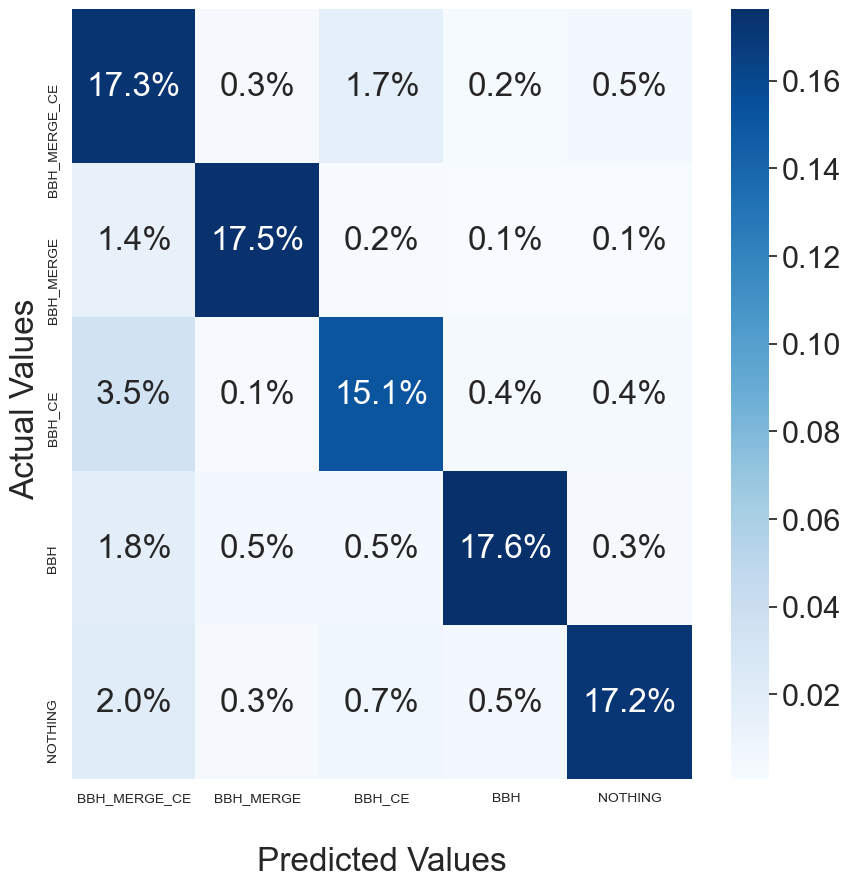

In [34]:
# Confusion matrix
# Evaluate confusion matrix

cm = metrics.confusion_matrix(ytest.argmax(axis=1), y_pred.argmax(axis=1))

##############################################################################

fig = plt.figure(figsize = [10,10])

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Blues')

ax.set_xticklabels(names , fontsize = 10)
ax.set_yticklabels(names , fontsize = 10)

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.show()
fig.savefig('conf_matrix_perc.png')

# Saving

In [71]:
filename = 'RandomForestBBH_5classes.sav'
pickle.dump(final_model, open(filename, 'wb'))

# Appendix - more plots

In [ ]:
fn = ['M1' , 'q' , 'Z' , 'a' , 'e']
cn = names

ext = final_model.estimators_[0]

sns.reset_defaults()

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=500)
out = tree.plot_tree(ext,
               feature_names = fn, 
               class_names=cn,
               filled = True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)

fig.savefig('rf_individualtree.png')

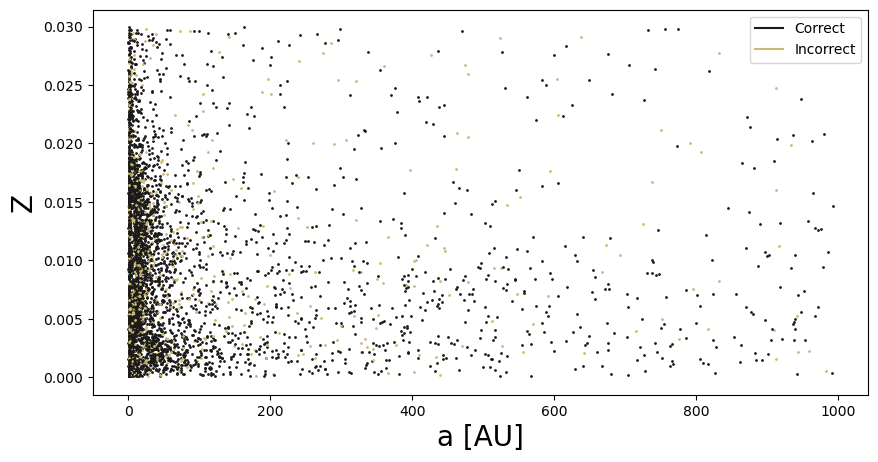

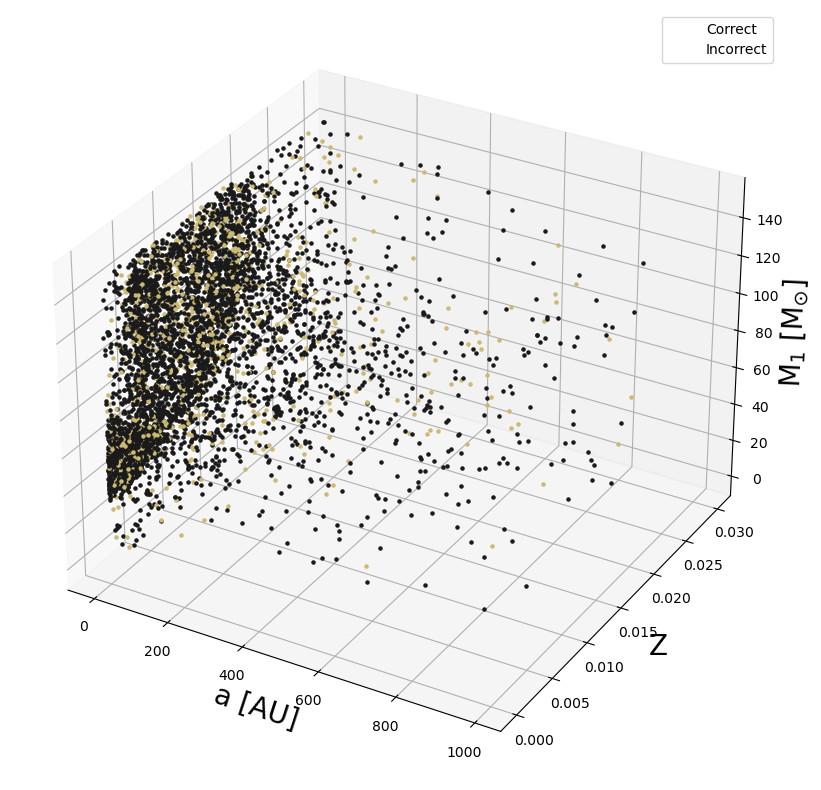

In [38]:
fig = plt.figure(figsize = (10, 5))

for i in range(len(ytest)):
    if ytest[i].tolist() == y_pred[i].tolist():
        plt.plot(Xtrain[i,3] , Xtrain[i,2], 'k.' , markersize = 2)
    else:
        plt.plot(Xtrain[i,3] , Xtrain[i,2], 'y.' , markersize = 2)
        
plt.xlabel('a [AU]' , fontsize = 20)
plt.ylabel('Z' , fontsize = 20)
plt.plot(0,0, c = 'k' , markersize = 0, label = 'Correct')
plt.plot(0,0, c = 'y', markersize = 0, label = 'Incorrect')
plt.legend()
plt.show()

fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d")

for i in range(len(ytest)):
    if ytest[i].tolist() == y_pred[i].tolist():
        ax.scatter3D(Xtrain[i,3] , Xtrain[i,2] , Xtrain[i,0] , c = 'k' , s = 5)
    else:
        ax.scatter3D(Xtrain[i,3] , Xtrain[i,2] , Xtrain[i,0] , c = 'y' , s = 5)
        
ax.set_xlabel('a [AU]' , fontsize = 20)
ax.set_ylabel('Z' , fontsize = 20)
ax.set_zlabel('M$_{1}$ [M$_{\odot}$]' , fontsize = 20)
ax.scatter3D(0,0,0, c = 'k' , s = 0, label = 'Correct')
ax.scatter3D(0,0,0, c = 'y', s = 0, label = 'Incorrect')
plt.legend()
plt.show()

C:\Users\mbaro\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


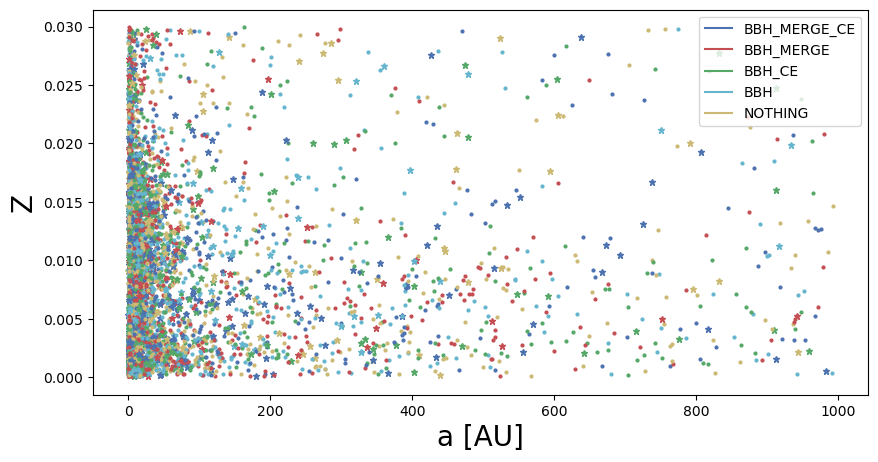

In [45]:
# FAI LA PCA E PLOTTA TUTTO IN 2 D e 3 D, POI FAI IL CLUSTERING
sns.reset_defaults()
colors = [str('b') , str('r') , str('g') , str('c') , str('y')]

fig = plt.figure(figsize = [10,5])
for i in range(len(ytest)):
    a = ytest[i]
    if np.all(a==[1,0,0,0,0]):
        
        if ytest[i].tolist() == y_pred[i].tolist():
            plt.plot(Xtrain[i,3] , Xtrain[i,2], colors[0] + 'o' , markersize = 2)
        else:
            plt.plot(Xtrain[i,3] , Xtrain[i,2], colors[0] + '*' , markersize = 5)
            
    elif np.all(a==[0,1,0,0,0]):
        
        if ytest[i].tolist() == y_pred[i].tolist():
            plt.plot(Xtrain[i,3] , Xtrain[i,2], colors[1] + 'o' , markersize = 2)
        else:
            plt.plot(Xtrain[i,3] , Xtrain[i,2], colors[1] + '*' , markersize = 5)
            
    elif np.all(a==[0,0,1,0,0]):
        
        if ytest[i].tolist() == y_pred[i].tolist():
            plt.plot(Xtrain[i,3] , Xtrain[i,2], colors[2] + 'o' , markersize = 2)
        else:
            plt.plot(Xtrain[i,3] , Xtrain[i,2], colors[2] + '*' , markersize = 5)
            
    elif np.all(a==[0,0,0,1,0]):
        
        if ytest[i].tolist() == y_pred[i].tolist():
            plt.plot(Xtrain[i,3] , Xtrain[i,2], colors[3] + 'o' , markersize = 2)
        else:
            plt.plot(Xtrain[i,3] , Xtrain[i,2], colors[3] + '*' , markersize = 5)
            
    elif np.all(a==[0,0,0,0,1]):
        if ytest[i].tolist() == y_pred[i].tolist():
            plt.plot(Xtrain[i,3] , Xtrain[i,2], colors[4] + 'o' , markersize = 2)
        else:
            plt.plot(Xtrain[i,3] , Xtrain[i,2], colors[4] + '*' , markersize = 5)
            
plt.ylabel('Z' , fontsize  = 20)
plt.xlabel('a [AU]' , fontsize  = 20)
for j in range(len(colors)):
    plt.plot(0,0,colors[j]+'-',markersize = 0 , label = names[j])
plt.legend()
plt.show()

#fig.savefig('PCA_2dim.png')

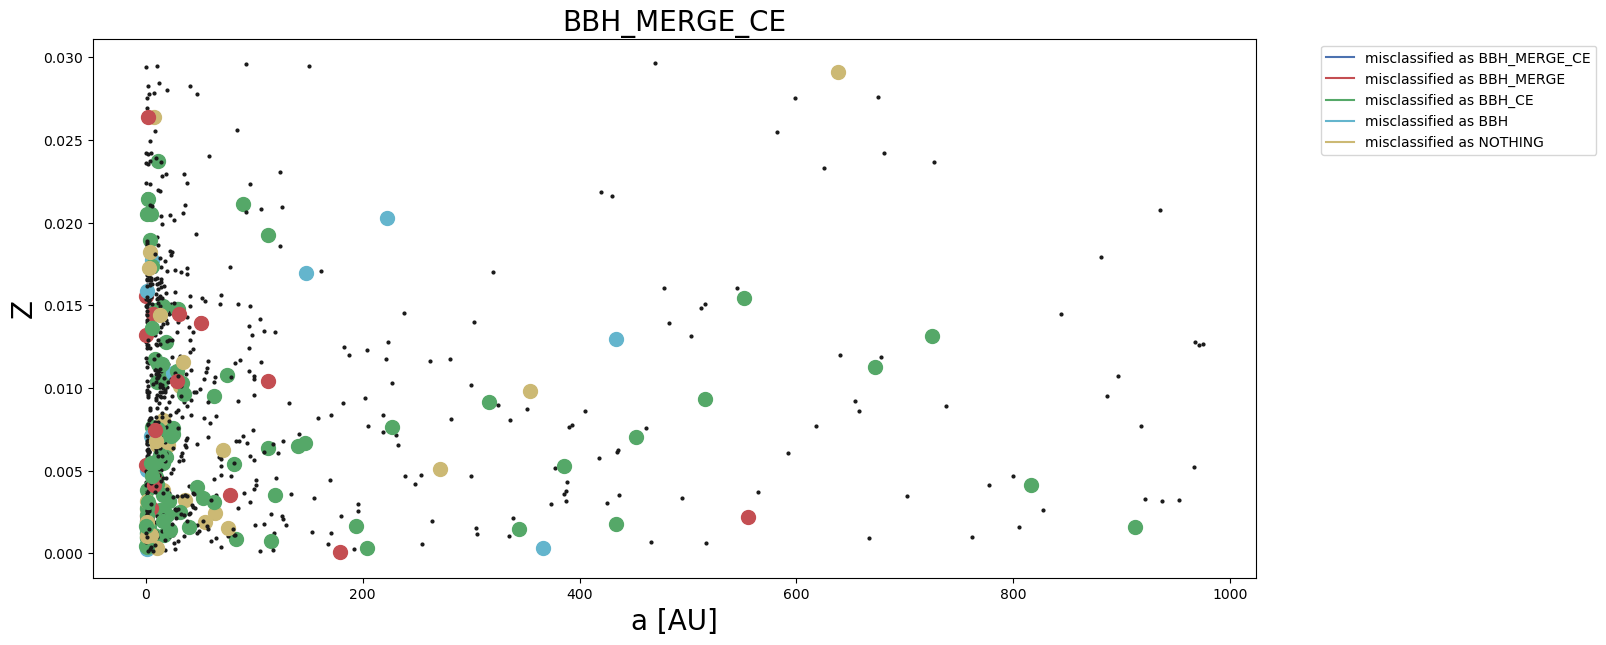

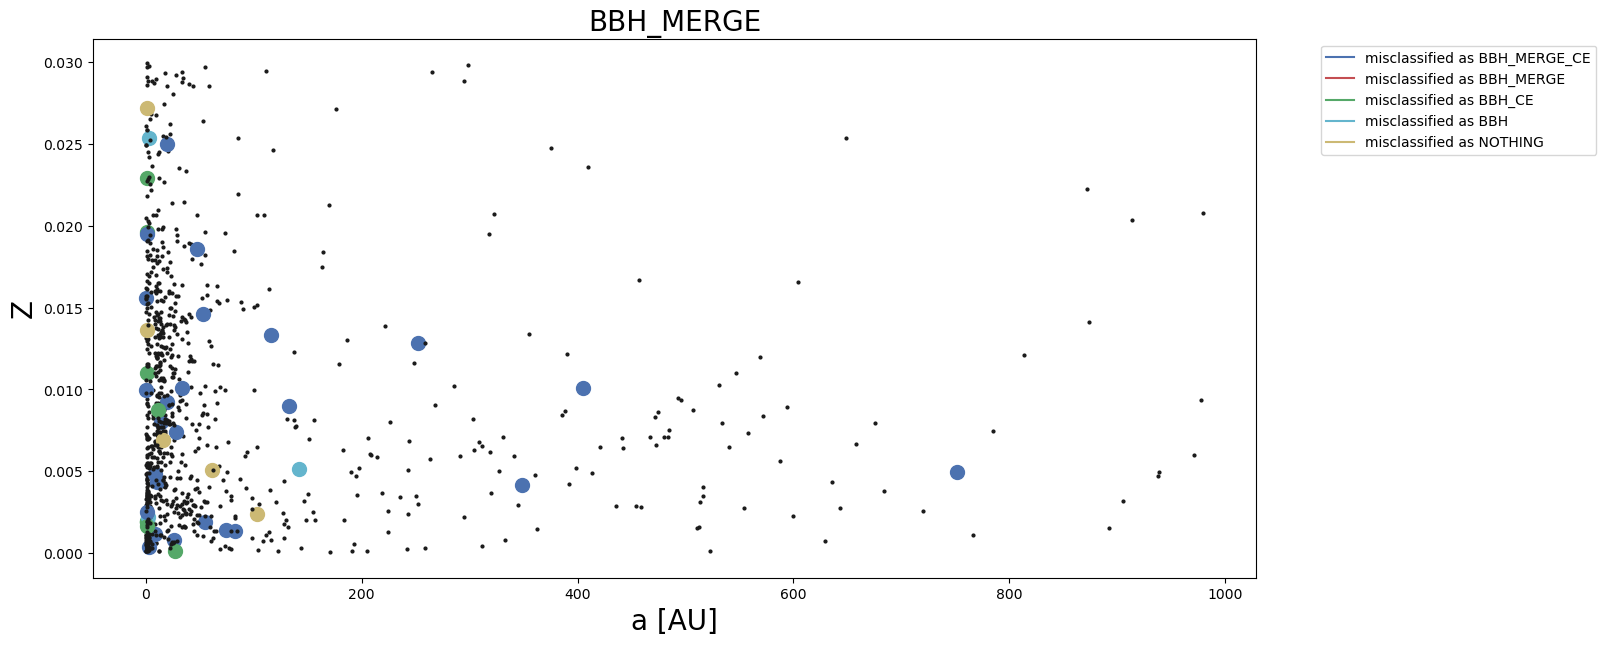

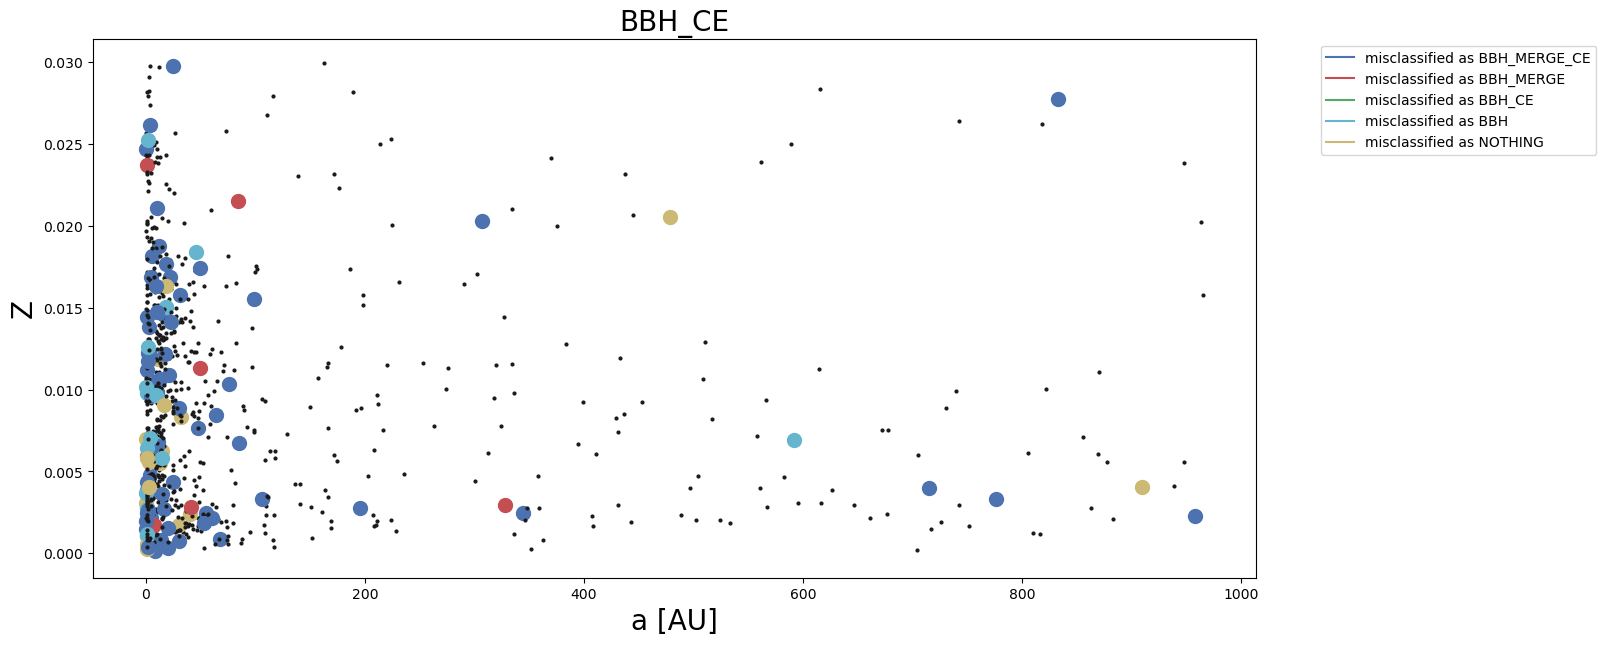

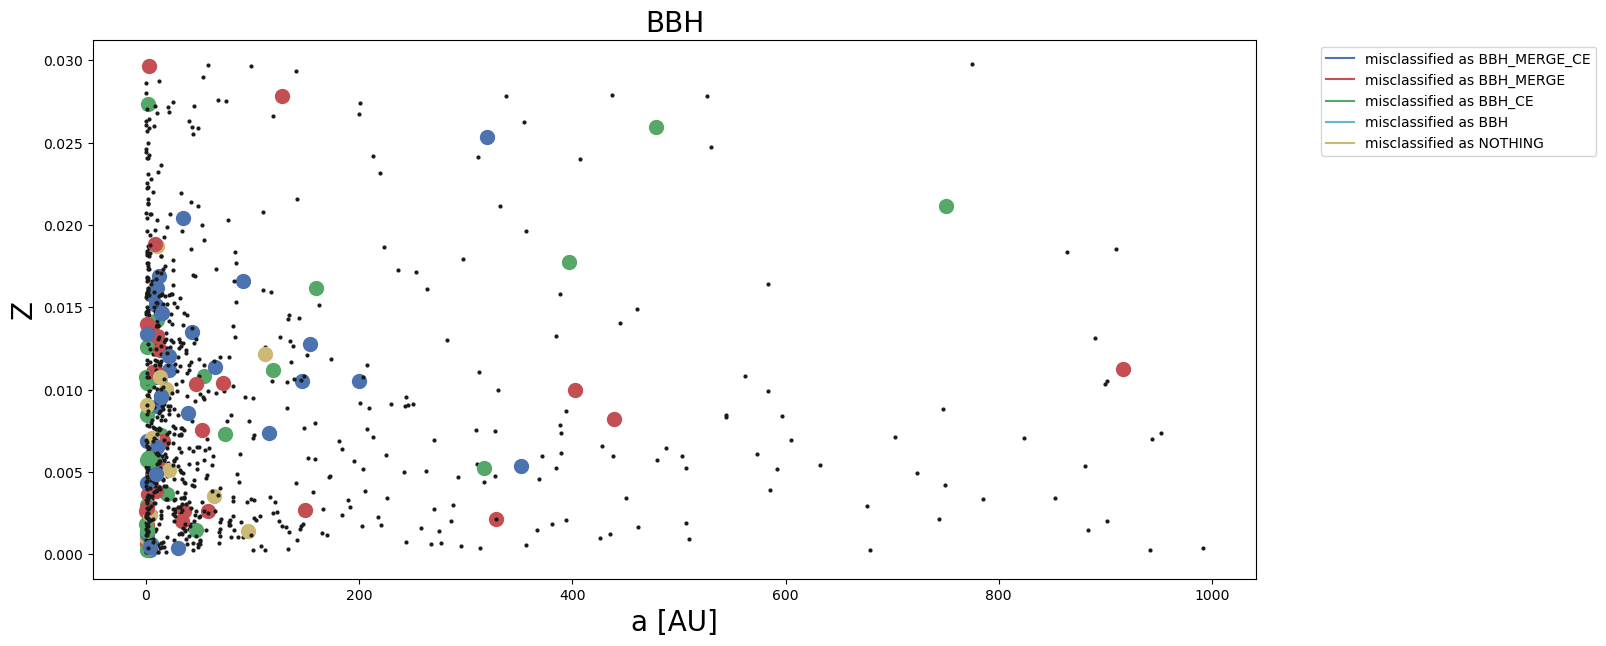

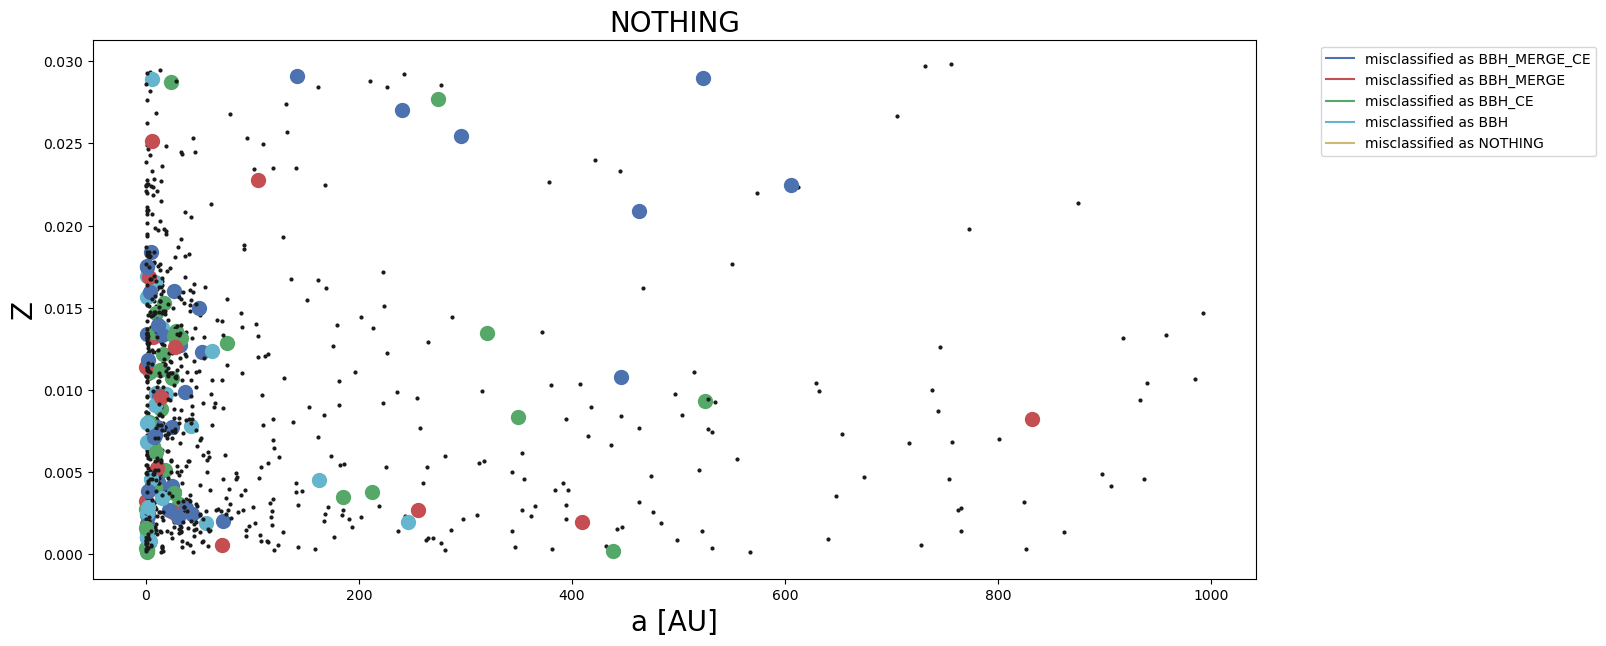

In [68]:
# PROVA A FARE UN MULTIPLOT TIPO CONFUSION MATRIX MA CON I GRAFICI
sns.reset_defaults()
colors = [str('b') , str('r') , str('g') , str('c') , str('y')]

Y = np.eye(5)

for k in range(len(Y[0])):
    fig = plt.figure(figsize = [15,7])
    for i in range(len(ytest)):
        a = ytest[i].tolist()
        b = Y[k].tolist()
        c = y_pred[i].tolist()
        if a == b:
            if ytest[i].tolist() == y_pred[i].tolist():
                plt.plot(Xtrain[i,3] , Xtrain[i,2], 'ko' , markersize = 2)
            else:
                for j in range(len(Y[:,0])):
                    if c == Y[j].tolist() and c != Y[k].tolist():
                        plt.plot(Xtrain[i,3] , Xtrain[i,2], colors[j] + 'o' , markersize = 10)
                        
    for f in range(len(colors)):
        plt.plot(0,0,colors[f]+'-',markersize = 0 , label = 'misclassified as ' + names[f])
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    
    plt.title(names[k] , fontsize = 20)
    plt.ylabel('Z' , fontsize  = 20)
    plt.xlabel('a [AU]' , fontsize  = 20)
    plt.show()
    fig.savefig('PCA_2dim_5classes_' + str(k) + '.png')

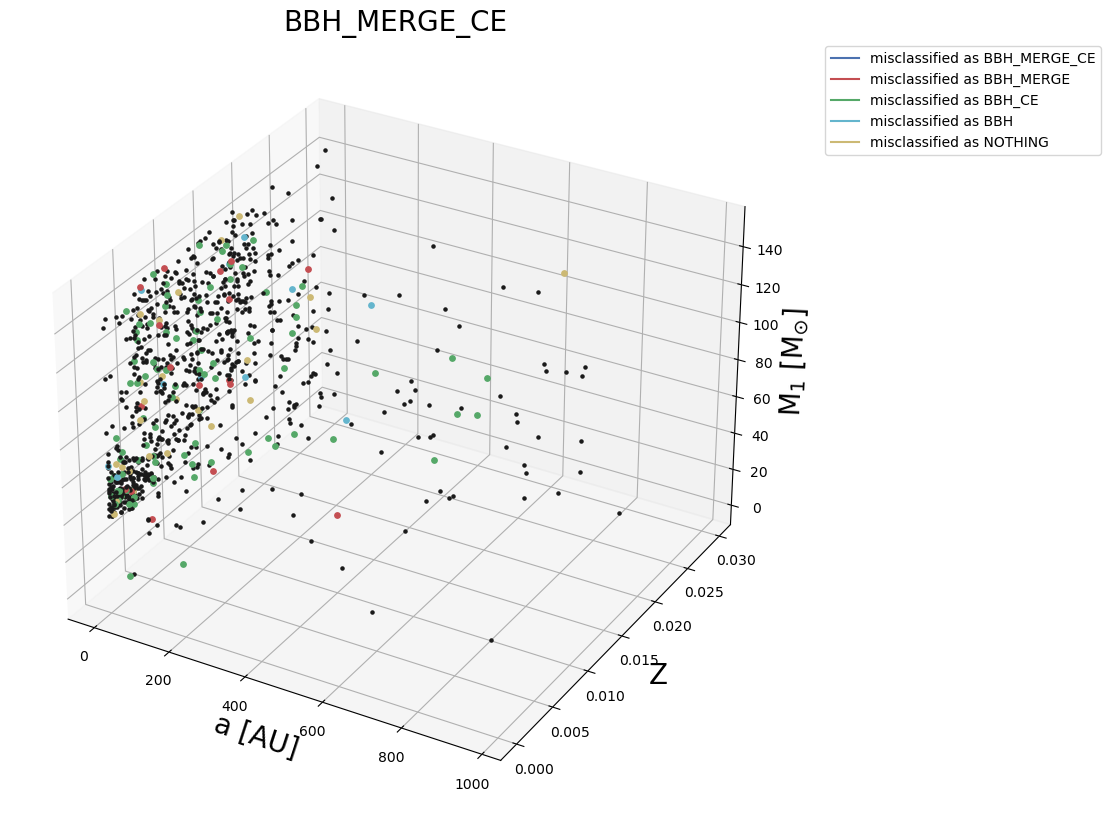

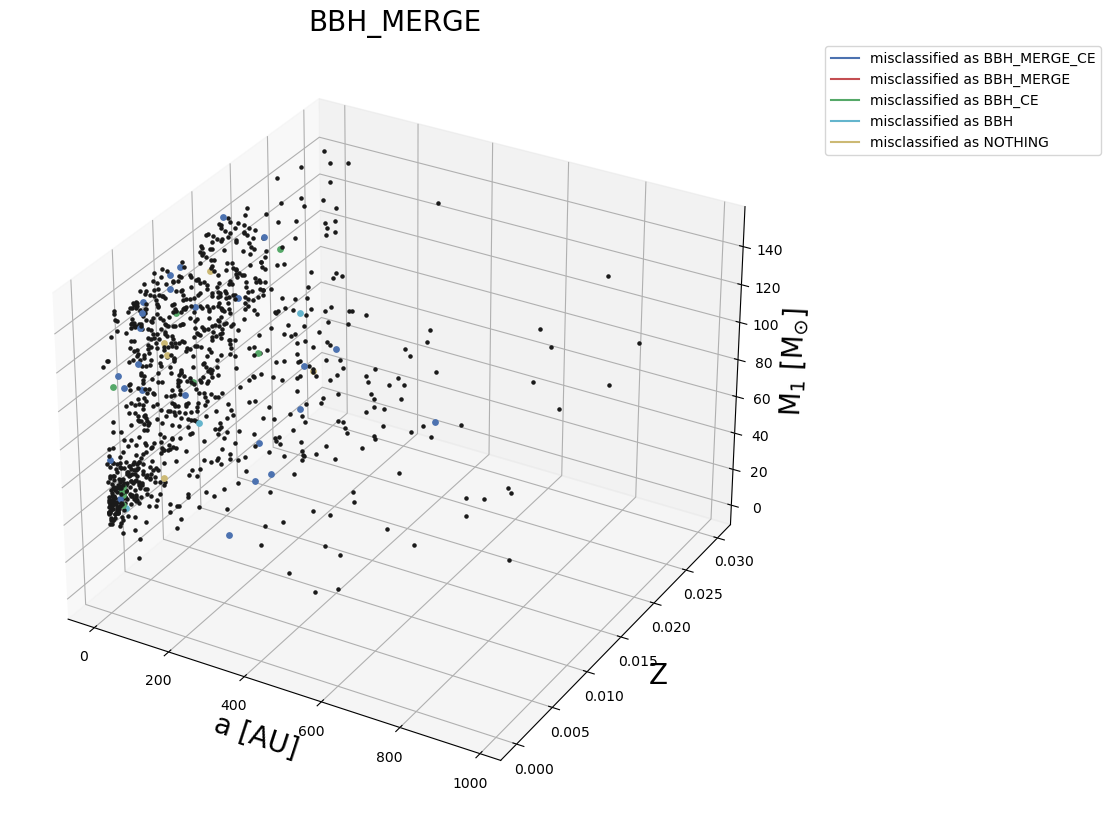

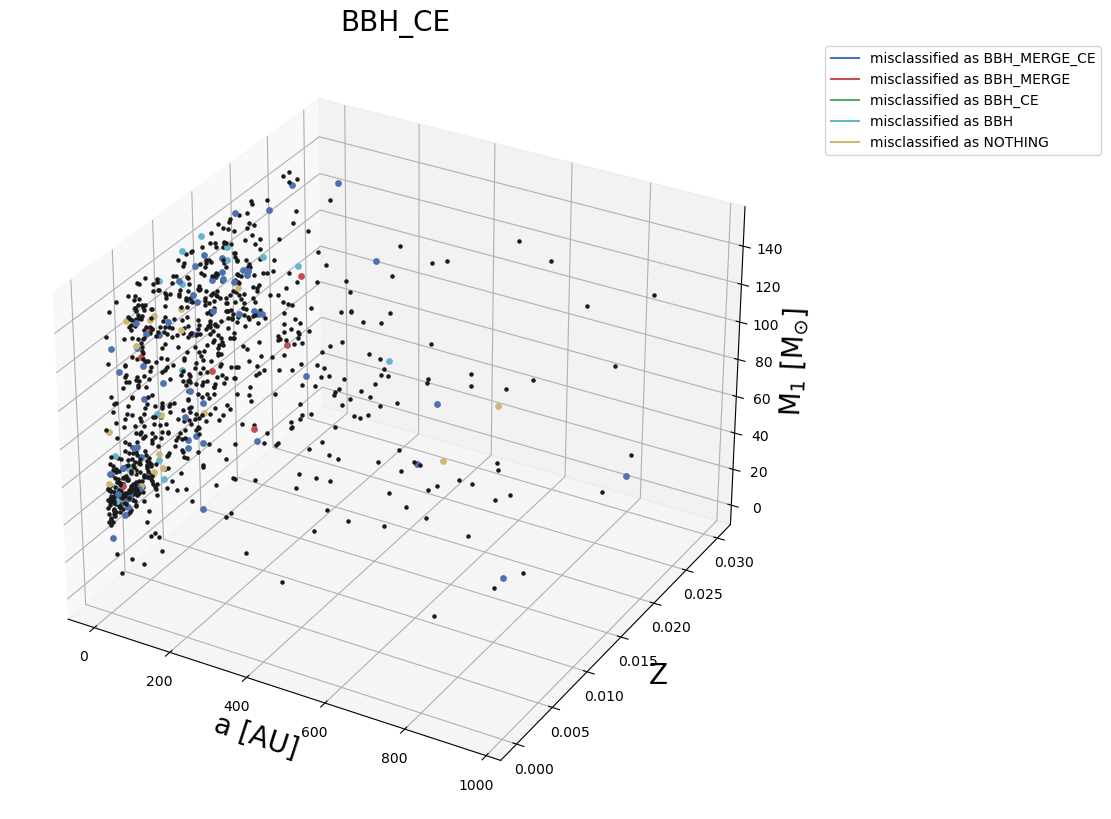

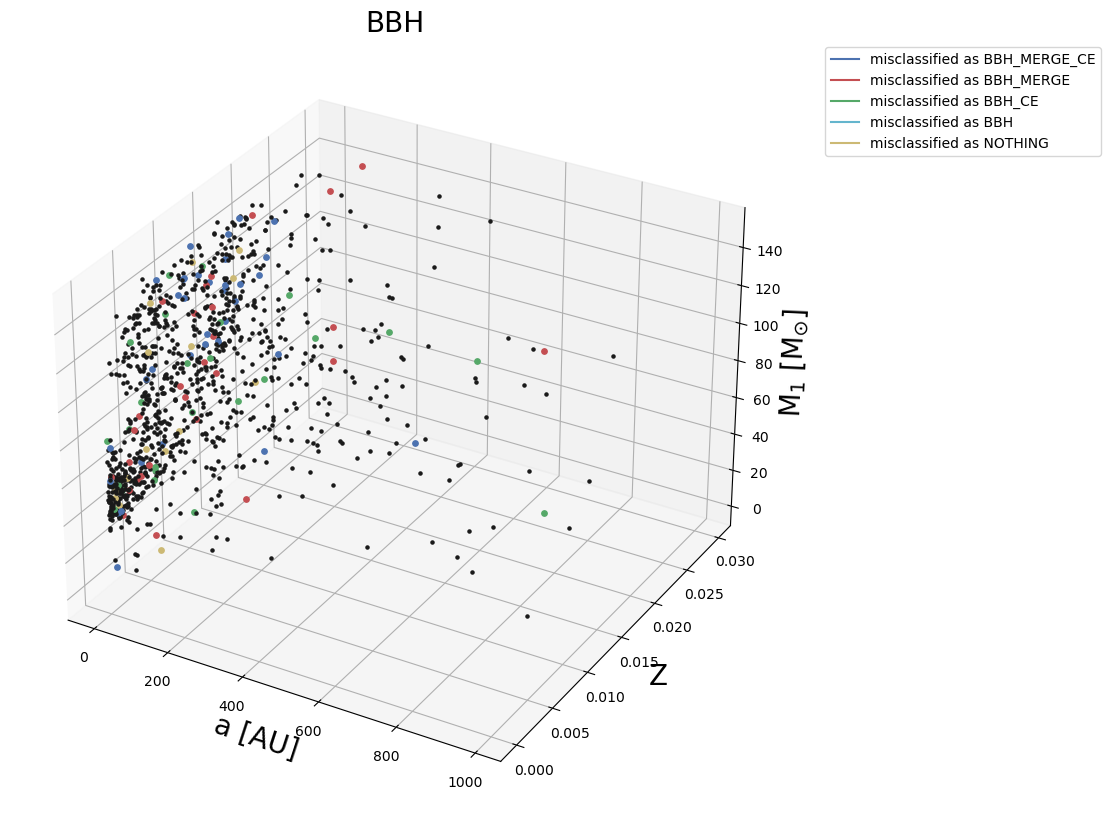

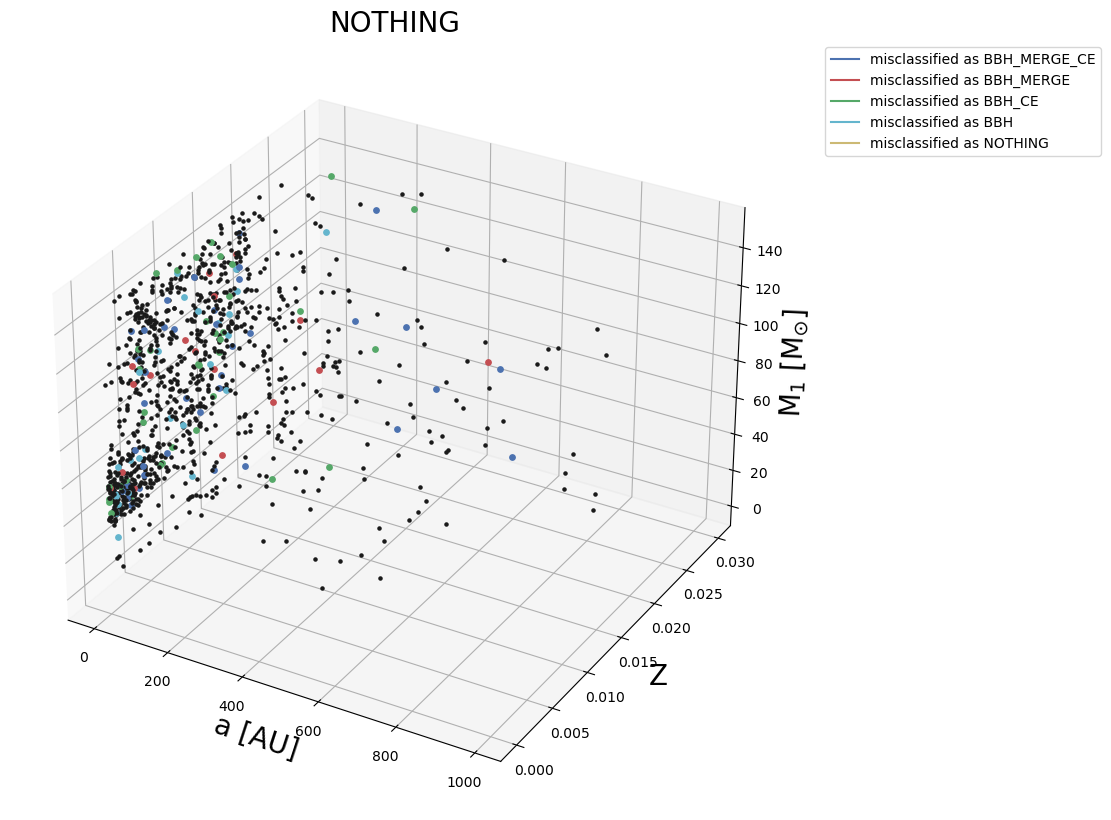

In [70]:
# FAI LA PCA E PLOTTA TUTTO IN 2 D e 3 D, POI FAI IL CLUSTERING
sns.reset_defaults()
colors = [str('b') , str('r') , str('g') , str('c') , str('y')]

Y = np.eye(5)

for k in range(len(Y[0])):
    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes(projection ="3d")
    for i in range(len(ytest)):
        a = ytest[i].tolist()
        b = Y[k].tolist()
        c = y_pred[i].tolist()
        if a == b:
            if ytest[i].tolist() == y_pred[i].tolist():
                ax.scatter3D(Xtrain[i,3] , Xtrain[i,2], Xtrain[i,0] , c = 'k' , s = 5)
            else:
                for j in range(len(Y[:,0])):
                    if c == Y[j].tolist() and c != Y[k].tolist():
                        ax.scatter3D(Xtrain[i,3] , Xtrain[i,2], Xtrain[i,0] , c = colors[j] , s = 15)
                        
    for f in range(len(colors)):
        plt.plot(0,0,0, c = colors[f] ,markersize = 1 , label = 'misclassified as ' + names[f])
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    
    ax.set_title(names[k] , fontsize = 20)
    ax.set_xlabel('a [AU]' , fontsize = 20)
    ax.set_ylabel('Z' , fontsize = 20)
    ax.set_zlabel('M$_{1}$ [M$_{\odot}$]' , fontsize = 20)
    plt.show()
    fig.savefig('PCA_3dim_5classes_' + str(k) + '.png')